## Analysis

You will need to install both `networkx` (using `pip`) and `matplotlib` (see <http://matplotlib.org/users/installing.html> for installation instructions)

In [1]:
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import matplotlib.pyplot as plt
from rdflib import ConjunctiveGraph
%matplotlib inline  

In [2]:
prefix = "PREFIX : <http://data.krw.d2s.labs.vu.nl/dataset/vocab/>"
TUTORIAL_REPOSITORY = "http://stardog.krw.d2s.labs.vu.nl/dataset"
endpoint = TUTORIAL_REPOSITORY + "/query"

In [3]:
def clearStardog():
    """Careful! This one clears the entire stardog repository specified in TUTORIAL_REPOSITORY"""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/clear"
    response = requests.post(post_url, headers={'Accept': 'text/plain'})
    
    print "Sent clear request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

def upload_file_to_stardog(filename, mimetype='application/trig'):
    """Well, obvious what this does... you can set the 'mimetype' to e.g. text/turtle if you want to upload a turtle file"""
    with open(filename,'r') as f:
        data = f.read()
        
    upload_to_stardog(data, mimetype=mimetype)
    
    return
    

def upload_to_stardog(data, mimetype='application/trig'):
    """Upload data to Stardog, you know this one from the previous assignments..."""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/add"
    response = requests.post(post_url, data=data, headers={'Accept': 'text/plain', 'Content-type': mimetype}, stream=True)

    print "Sent add request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

    
def getClasses(reasoning='true', max=None):
    """Get all classes from the repo, optionally with a limit of `max`"""
    if max is None :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class }"""
    else :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class } LIMIT """ + str(max)
    
    return [r['c']['value'] for r in runQuery(query, reasoning)]
    

def getInstances(className, reasoning='true'):
    """Get the instances for a class.. be sure to include < and > around its URI"""
    query = prefix + """
    SELECT ?i WHERE {{?i a {} . }}
    """.format(className)
    
    return [r['i']['value'] for r in runQuery(query, reasoning)]

def countUsage(reasoning='true', max=None):
    """Count the number of occurrences of a resource. Will differ significantly if reasoning is 'false'"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'resource' in r:
            index[unicode(r['resource']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index


def countClassUsage(reasoning='true', max=None):
    """Count how many (inferred) instances a class has"""
    query = """
        SELECT ?class (COUNT(?resource) as ?count) WHERE {
            ?resource a ?class . 
        } GROUP BY ?class ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'class' in r:
            index[unicode(r['class']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index

def countUsageLocal(rdfgraph, max=None):
    """Count usage of a resource on a local RDFLib graph"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY ?resource
    """
    
    results = g.query(query)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
            
        index[unicode(r['resource'])] = int(r['count'])
        
        count += 1
    
    return index
    

def runQuery(query, reasoning='true'):
    """Run a SPARQL query against the endpoint"""
    sparql = SPARQLWrapper(endpoint)

    sparql.setQuery(query)

    sparql.setReturnFormat(JSON)
    sparql.addParameter('Accept','application/sparql-results+json')

    sparql.addParameter('reasoning',reasoning)

    response = sparql.query().convert()

    return response['results']['bindings']

### Example analysis

Upload the example files to Stardog

In [7]:
#upload_file_to_stardog('o1.trig')
#upload_file_to_stardog('o2.trig')
#upload_file_to_stardog('d1.trig')
#upload_file_to_stardog('d2.trig')

Now get all classes from the repository. Select one, and use its URI to retrieve instances.

(Play around with reasoning 'false' and 'true')

In [4]:
getClasses(max=10000, reasoning='true')

EndPointInternalError: EndPointInternalError: endpoint returned code 500 and response.

In [10]:
getInstances('<http://www.w3.org/2002/07/owl#Thing>', reasoning='true')

[u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/LargeSpotTest',
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/SmallSpotTest',
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/TestExhibit',
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/TestVenueExhibit',
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/TestPlay',
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/TestVenuePlay']

### Locally

Load the example files in an RDFLib graph (locally). Note that a large graph may become problematic (given memory limitations).

A `ConjunctiveGraph` object allows for loading named graphs, but hides them (i.e. you don't need to think about the graphs when querying the data).

In [11]:
g = ConjunctiveGraph()

g += g.parse('museums.trig', format='trig')
g += g.parse('parking_slots.trig', format='trig')
g += g.parse('theaters.trig', format='trig')
#g += g.parse('d2.trig', format='trig')


Several simple statistics. The following code uses the `index` variable. Adjust where needed (e.g. replace `index` with `index_remote`)

In [12]:
index = countUsageLocal(g)

In [13]:
index

{u'https://media.iamsterdam.com/ndtrc/Images/20150122/2603846f-5db0-4481-bfe8-b39169c22c5f.jpg': 1,
 u'Date multiple: a partire da Gi 4 febbraio 2016 Da Gi 19 maggio 2016.': 1,
 u'Studio de Bakkerij - Brieven uit de oorlog (10+)': 1,
 u'Di 17 Avril 2016 20:15 heure.': 1,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Azartplein_zijweg_45-47': 4,
 u'Vi 20 Mayo 2016 20:30 Hora,\r\nSa 21 Mayo 2016 20:30 Hora,\r\nDo 22 Mayo 2016 19:30 Hora.': 1,
 u'OOSTZANERDIJK 151': 1,
 u'(4 p.p. vanaf Willem Sandbergplein)': 1,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Ingenhouszhof_47': 4,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Jan_Pieter_Heijestraat_62_-_74': 4,
 u'Theater Bellevue Amsterdam | 23 en 24 april 2016. Deze voorstelling maakt deel uit van het Pop Arts Festival. Dik en Adam, twee traditionele clowns, zijn op miraculeuze wijze in een heel wonderlijke wereld beland. Hun bewegingen lijken er niet van zichzelf te zijn. Het is alsof iemand ande

In [14]:
index_remote = countUsage(reasoning='false')

In [15]:
index_remote

{u'Di 17 Avril 2016 20:15 heure.': 1,
 u'Date multiple: a partire da Gi 4 febbraio 2016 Da Gi 19 maggio 2016.': 1,
 u'Lu -Do : 11:00 - 17:00 Hora,\nCerrado Mi 27 Abril 2016\nCerrado Lu 3 Octubre 2016\nCerrado Ma 4 Octubre 2016\nCerrado Mi 12 Octubre 2016.': 1,
 u'bedrijfsverzamelgebouw': 1,
 u'https://media.iamsterdam.com/ndtrc/Images/20150122/2603846f-5db0-4481-bfe8-b39169c22c5f.jpg': 1,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Azartplein_zijweg_45-47': 4,
 u'OOSTZANERDIJK 151': 1,
 u'(4 p.p. vanaf Willem Sandbergplein)': 1,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Ingenhouszhof_47': 4,
 u'Opgediept': 1,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Jan_Pieter_Heijestraat_62_-_74': 4,
 u'Theater Bellevue Amsterdam | 23 en 24 april 2016. Deze voorstelling maakt deel uit van het Pop Arts Festival. Dik en Adam, twee traditionele clowns, zijn op miraculeuze wijze in een heel wonderlijke wereld beland. Hun bewegingen lijken er niet van zi

In [16]:
index_classes = countClassUsage(reasoning='true')

In [17]:
index_classes

{u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Event': 477,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/ParkingSlot': 531,
 u'http://rdfs.org/ns/void#Dataset': 40,
 u'http://rdfs.org/ns/void#Linkset': 1,
 u'http://www.w3.org/2002/07/owl#Thing': 1663}

Get the frequencies for each resource, and sort by frequency value.

Plot them at loglog scale

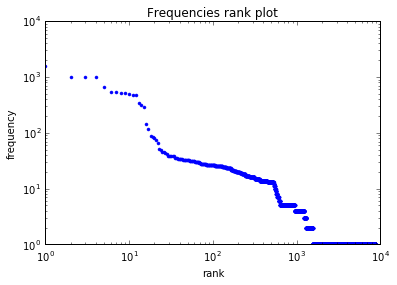

In [18]:
frequencies_by_value = sorted(index.values(), reverse=True)

plt.loglog(frequencies_by_value,'b-',linestyle='None', marker='.')
plt.title("Frequencies rank plot")
plt.ylabel("frequency")
plt.xlabel("rank")

Get the frequencies for each resource, and sort by URI name (i.e. alphabetically)

Plot them at loglog scale

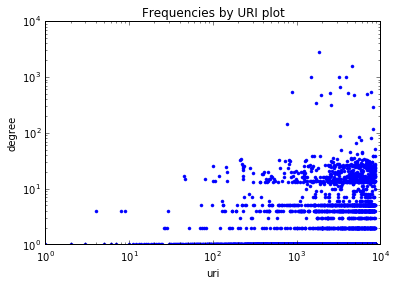

In [19]:
frequencies_by_URI = index.values()

plt.loglog(frequencies_by_URI,'b-',linestyle='None', marker='.')
plt.title("Frequencies by URI plot")
plt.ylabel("degree")
plt.xlabel("uri")

### Network Analysis

Build a directed `networkx` graph from the RDF graph

In [20]:
def buildNetwork(rdfgraph, query = """SELECT * WHERE {?source ?edge ?target.}""", max=None):
    ## Query is assumed to have a source, target and edge
    
    results = g.query(query)
    
    G = nx.DiGraph()
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        G.add_edge(r['source'], r['target'], {'type': r['edge']})
        
        count += 1
        
    return G


In [21]:
G = buildNetwork(g, max=10000)

Get the degrees for each node in the graph, and sort them from large to small

In [22]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence

# And see what it looks like...
degree_sequence

[463,
 425,
 279,
 121,
 77,
 70,
 65,
 54,
 45,
 41,
 38,
 38,
 37,
 37,
 35,
 35,
 35,
 34,
 34,
 33,
 33,
 32,
 31,
 31,
 31,
 31,
 30,
 30,
 30,
 30,
 30,
 30,
 29,
 29,
 29,
 29,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 26,
 26,
 26,
 26,
 26,
 26,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 

Plot the graph using a spring layout (warning, may be very slow for large graphs)

In [1]:
# draw graph in inset
plt.axes([1.45,1.45,1.45,1.45])
#Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
pos=nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G,pos,node_size=50)
nx.draw_networkx_edges(G,pos,alpha=0.4)

# plt.savefig("graph.png")
plt.show()

NameError: name 'plt' is not defined

Plot the degrees at loglog scale

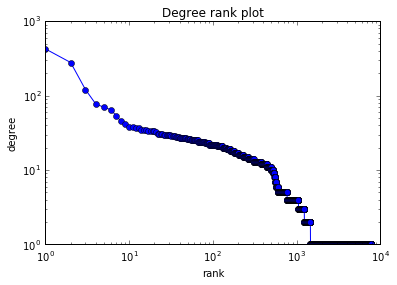

In [24]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

You can also do Pagerank on the graph (have a look at the `networkx` documentation)

In [25]:
nx.pagerank(G)

{rdflib.term.Literal(u'<h2>Collezione</h2>\r\nL&rsquo;<strong>Hermitage Amsterdam</strong> organizza mostre con opere provenienti dalla collezione russa che include dipinti, opere grafiche, sculture, oggetti d&rsquo;arte applicata e reperti archeologici.\r\nIl museo ha una speciale ala dedicata ai bambini, dove i piccoli visitatori possono partecipare ai laboratori artistici che puntano allo sviluppo della creativit&agrave;.<br />\r\n<br />\r\n<h2>Il legame con i Paesi Bassi</h2>\r\nLo zar russo Pietro il Grande aveva un legame speciale con Amsterdam, citt&agrave; dove visse per diversi anni. Fond&ograve; il primo museo pubblico russo e alcune delle prime opere esposte furono acquistate proprio nei Paesi Bassi. A quel tempo, il museo offriva ai visitatori un bicchierino di vodka per invitarli a entrare.', lang=u'it'): 0.00012066922115588892,
 rdflib.term.Literal(u'Tu -Su: 11:00 - 17:00 hour,\r\nClosed on We 27 April 2016.', lang=u'en'): 0.00011956056015123707,
 rdflib.term.Literal(u'BI